## Scenario B: Bid Pricing & Win-Rate

Commercial janitorial and day porter bids are highly price-competitive.
My goal is to identify bid pricing that maximizes expected profit while maintaining a high win probability and meeting a 10% minimum margin requirement.

This notebook demonstrates a technical prototype pipeline including:
- Synthetic historical bid data creation
- Synthetic proposal text & regex-based feature extraction
- Logistic win-rate modeling + probability calibration
- Expected profit optimization across candidate prices
- Guardrails to enforce pricing minimum 10% margin threshold

This prototype simulates realistic pricing dynamics based on business intuition and constraints.

### Pipeline Flow Diagram

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, json, random
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, brier_score_loss
from scipy.optimize import minimize_scalar

np.random.seed(42)

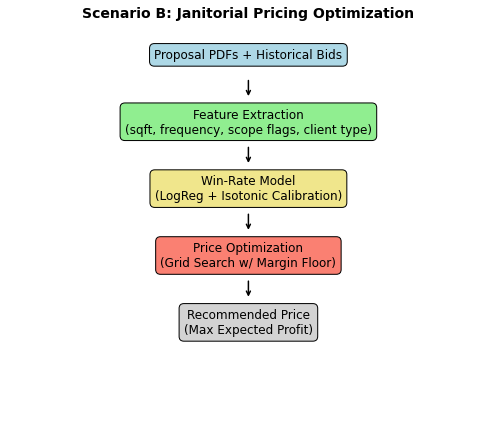

In [24]:
fig, ax = plt.subplots(figsize=(7,6))
ax.axis('off')

# Define vertical positions
boxes = [
    ("Proposal PDFs + Historical Bids", 0.92, "lightblue"),
    ("Feature Extraction\n(sqft, frequency, scope flags, client type)", 0.75, "lightgreen"),
    ("Win-Rate Model\n(LogReg + Isotonic Calibration)", 0.58, "khaki"),
    ("Price Optimization\n(Grid Search w/ Margin Floor)", 0.41, "salmon"),
    ("Recommended Price\n(Max Expected Profit)", 0.24, "lightgray")
]

# Draw boxes
for text, y, color in boxes:
    ax.text(0.5, y, text, ha='center', va='center',
            fontsize=12, bbox=dict(boxstyle="round,pad=0.4", fc=color))

# Arrows
arrow_links = [
    (0.92, 0.75),
    (0.75, 0.58),
    (0.58, 0.41),
    (0.41, 0.24),
]

for y1, y2 in arrow_links:
    mid = (y1 + y2) / 2
    ax.annotate("",
                xy=(0.5, mid - 0.025),
                xytext=(0.5, mid + 0.025),
                arrowprops=dict(arrowstyle="->", lw=1.5))

plt.title("Scenario B: Janitorial Pricing Optimization", fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("docs/flowchart.png", dpi=300)
plt.show()

### Assumptions & Synthetic Data Setup

- Only non-union scenarios.
- Minimum 10% margin floor applies.
- Corporate office cleaning with buildings between 5k–100k sqft
- Price per sqft range: $0.05-$0.25
- Cost per sqft range: $0.035-$0.20
- Proposal text is unstructured PDFs.
- Historical data includes 1,200 synthetic bids for prototyping, features  including: client type, square footage, cost, submitted price, price per sqft, year, timestamp, award flag.
- Success metrics: maximize revenue while keeping margin >= 10% and reasonable win probability.

In [2]:
# Generate Synthetic Bid Data

# Number of historical bids used for prototyping
n_bids = 1200

# Realistic operating ranges for commercial office cleaning
sqft_min, sqft_max = 5000, 100000
price_per_sqft_min, price_per_sqft_max = 0.05, 0.25
cost_per_sqft_min, cost_per_sqft_max = 0.035, 0.20

# Client industry categories
client_types = ['finance','tech','legal','consulting','real_estate']

rows = []
start_date = datetime(2015,1,1)
for i in range(n_bids):
    # Square footage drawn from exponential distribution
    sqft = int(np.random.exponential(scale=15000)) + 5000
    sqft = max(sqft_min, min(sqft, sqft_max))
    
    client_type = random.choice(client_types)
    
    # Generate cost & submitted price per sqft independently
    cost_per_sqft = np.random.uniform(cost_per_sqft_min, cost_per_sqft_max)
    cost = cost_per_sqft * sqft
    price_per_sqft = np.random.uniform(price_per_sqft_min, price_per_sqft_max)
    submitted_price = price_per_sqft * sqft
    
    # Randomize submission timing across 10 years
    ts = start_date + timedelta(days=random.randint(0, 365*10))
    
    # Synthetic Win Probability
    # Pricing sensitivity simulated through price ratio vs. benchmark
    price_ratio = price_per_sqft / 0.12
    # Industry factor influences how sensitive a client is to price
    client_factor = {'finance':0.05, 'tech':0.10, 'legal':0.03, 'consulting':0.06, 'real_estate':0.08}[client_type]
    
    # Logistic-style map to keep probs in (0,1)
    base_prob = 0.45 - 0.8 * (price_ratio - 1) * 0.5 + client_factor
    base_prob = 1 / (1 + np.exp(-(base_prob - 0.5)*4))
    
    # Add realism by noise + clipping for boundaries
    final_prob = np.clip(base_prob + np.random.normal(0,0.06), 0.01, 0.98)
    award_flag = int(np.random.rand() < final_prob)
    
    rows.append({
        'bid_id': f'BID_{i:04d}',
        'client_id': f'C_{random.randint(1,300):03d}',
        'client_type': client_type,
        'sqft': sqft,
        'cost': round(cost,2),
        'submitted_price': round(submitted_price,2),
        'price_per_sqft': round(price_per_sqft,4),
        'year': ts.year,
        'timestamp': ts.strftime("%Y-%m-%d"),
        'award_flag': award_flag
    })

df_bids = pd.DataFrame(rows)
print("Synthetic bids:", df_bids.shape)

Synthetic bids: (1200, 10)


In [3]:
df_bids.head()

,bid_id,client_id,client_type,sqft,cost,submitted_price,price_per_sqft,year,timestamp,award_flag
0,BID_0000,C_001,legal,12039,2309.90,2364.45,0.1964,2021,2021-12-13,1
1,BID_0001,C_203,consulting,5897,1049.19,1003.81,0.1702,2017,2017-07-10,0
2,BID_0002,C_151,finance,5311,1035.83,1149.77,0.2165,2020,2020-06-17,0
3,BID_0003,C_286,real_estate,10441,1269.47,1424.04,0.1364,2022,2022-01-23,1
4,BID_0004,C_100,legal,19195,1113.63,2081.29,0.1084,2017,2017-09-06,0


### Proposal Text Extraction (Unstructured → Structured)

I simulate proposal narratives from PDFs and extract key features:

In [4]:
# Example proposal text samples representing OCR-extracted narrative content
sample_texts = [
    "Scope of Work: Daily janitorial services for 15,000 sqft corporate office. Includes restrooms, lobby, kitchen pantry, and conference rooms. Frequency: 5 days/week. Contract length: 12 months. Special requirements: after-hours cleaning for events twice a month.",
    "Proposal: Weekly cleaning for 8,000 sqft office. Tasks include floor care, trash removal and restroom maintenance. Frequency: 3x per week. Client expects deep-clean quarterly.",
    "Scope: Office complex 45,000 sqft with multiple floors. Services: day porter + daily cleaning for common areas, windows cleaning monthly. Requires background-checked staff.",
    "Request: One-time deep clean for 10,000 sqft after renovation. Scope: floor stripping/waxing, dust removal. Not recurring.",
    "Proposal: 60,000 sqft headquarters. Daily daytime porter and nightly janitorial services. Includes floor care, kitchen areas and carpet cleaning. Contract length 24 months.",
    "Scope: 7,500 sqft small office suite. Frequency: 2 days/week. No specialized services.",
    "Proposal: 25,000 sqft, 5 days/week, requires green cleaning supplies and floor waxing every 3 months. Client requests certificate of insurance.",
    "RFP narrative: 12,000 sqft, high-security financial firm, requires employee background checks and weekend cleaning. Frequency: 6 days/week.",
    "Request: 30,000 sqft, including restrooms, kitchenettes, and conference centers. Frequency daily. Special cleaning for server rooms require equipment handling.",
    "Proposal: 9,000 sqft law firm office. Requires discreet after-hours cleaning. Frequency: nightly.",
    "RFP: 18,000 sqft tech firm with frequent events; needs flexible schedule and day porter services on weekdays.",
    "Proposal: 20,000 sqft retail-office mix, nightly cleaning and weekly deep cleaning of all bathrooms and kitchens."
]

In [5]:
# Extraction functions
import re

# Extract sqft numbers that appear next to "sqft" tokens
def extract_sqft(text):
    m = re.search(r'([0-9]{1,3}(?:,[0-9]{3})+|[0-9]{4,6})\s*(sqf|sqft|sq ft|square feet|square footage)', text, re.I)
    if m:
        val = m.group(1).replace(",", "")
        return int(val)
    return None

# Extract cleaning frequency if mentioned
def extract_frequency(text):
    text_l = text.lower()
    if 'daily' in text_l or 'nightly' in text_l: return 'daily'
    if '5 days/week' in text_l or '5 days' in text_l: return '5_per_week'
    if '3x per week' in text_l or '3 times' in text_l or '3x' in text_l: return '3_per_week'
    if 'weekly' in text_l: return 'weekly'
    m = re.search(r'(\d)\s*days?/week', text_l)
    if m: return f"{m.group(1)}_per_week"
    return None

# Extract presence of key scope indicators
def extract_scope_flags(text):
    text_l = text.lower()
    flags = {}
    flags['restrooms'] = any(k in text_l for k in ['restroom','bathroom','toilet'])
    flags['kitchen'] = any(k in text_l for k in ['kitchen','pantry'])
    flags['conference'] = any(k in text_l for k in ['conference','meeting room'])
    flags['windows'] = any(k in text_l for k in ['window','windows'])
    flags['floor_wax'] = any(k in text_l for k in ['wax','floor waxing','stripping'])
    return flags

# Apply extraction to simulated sample proposals
extracted_data = []
for i, txt in enumerate(sample_texts):
    data = {
        "proposal_id": i+1,
        "sqft_prop": extract_sqft(txt),
        "frequency": extract_frequency(txt)
    }
    data.update(extract_scope_flags(txt))
    extracted_data.append(data)

df_proposals = pd.DataFrame(extracted_data)

In [6]:
df_proposals.head()

,proposal_id,sqft_prop,frequency,restrooms,kitchen,conference,windows,floor_wax
0,1,15000,daily,True,True,True,False,False
1,2,8000,3_per_week,True,False,False,False,False
2,3,45000,daily,False,False,False,True,False
3,4,10000,None,False,False,False,False,True
4,5,60000,daily,False,True,False,False,False


### Merge Structured & Text-Based Features

I match text proposals to bids using nearest sqft which is good proxy for similarity.

In [7]:
# Merge bids with proposals using nearest sqft
df_bids_sorted = df_bids.sort_values('sqft').reset_index(drop=True)
df_proposals_sorted = df_proposals.sort_values('sqft_prop').reset_index(drop=True)

df = pd.merge_asof(df_bids_sorted, df_proposals_sorted,
                   left_on='sqft', right_on='sqft_prop',
                   direction='nearest')

In [8]:
df.head()

,bid_id,client_id,client_type,sqft,cost,submitted_price,price_per_sqft,year,timestamp,award_flag,proposal_id,sqft_prop,frequency,restrooms,kitchen,conference,windows,floor_wax
0,BID_0548,C_037,consulting,5000,518.67,772.51,0.1545,2021,2021-01-05,1,6,7500,2_per_week,False,False,False,False,False
1,BID_0433,C_026,finance,5082,184.30,476.76,0.0938,2019,2019-03-21,1,6,7500,2_per_week,False,False,False,False,False
2,BID_0925,C_166,tech,5090,584.52,379.97,0.0746,2018,2018-10-01,1,6,7500,2_per_week,False,False,False,False,False
3,BID_0218,C_049,tech,5096,419.71,883.57,0.1734,2017,2017-02-15,1,6,7500,2_per_week,False,False,False,False,False
4,BID_0901,C_017,real_estate,5105,518.54,494.93,0.0970,2015,2015-12-26,0,6,7500,2_per_week,False,False,False,False,False


### Feature Engineering & Model Training

I model the win-rate using proposal features that influence competitiveness and customer perception.

In [9]:
# Feature engineering

# Price per sqft and log sqft
df['price_per_sqft'] = df['submitted_price'] / (df['sqft'] + 1)
df['log_sqft'] = np.log1p(df['sqft'])

# One-hot encode client industry
df = pd.get_dummies(df, columns=['client_type'], drop_first=True)

# Scope flags extracted earlier
text_flags = ['restrooms','kitchen','conference','windows','floor_wax']

# Final model feature set
feature_cols = ['price_per_sqft','log_sqft'] + \
               [c for c in df.columns if c.startswith('client_type_')] + text_flags
X = df[feature_cols].fillna(0)
y = df['award_flag']

print("Feature cols:", feature_cols)

Feature cols: ['price_per_sqft', 'log_sqft', 'client_type_finance', 'client_type_legal', 'client_type_real_estate', 'client_type_tech', 'restrooms', 'kitchen', 'conference', 'windows', 'floor_wax']


In [10]:
# Train/test split, scaling, logistic reg, calibration
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve

# Standardize numeric inputs
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
# Hold out 20% for testing
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42, shuffle = True)

# Baseline logistic regression
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
# Improve probability accuracy with isotonic calibration
cal = CalibratedClassifierCV(clf, method='isotonic', cv=5)
cal.fit(X_train, y_train)

# Compare probability quality
probs_uncal = clf.predict_proba(X_test)[:,1]
probs_cal = cal.predict_proba(X_test)[:,1]

print("ROC AUC (uncal):", round(roc_auc_score(y_test, probs_uncal),3))
print("ROC AUC (cal):", round(roc_auc_score(y_test, probs_cal),3))
print("Brier (uncal):", round(brier_score_loss(y_test, probs_uncal),4))
print("Brier (cal):", round(brier_score_loss(y_test, probs_cal),4))

ROC AUC (uncal): 0.686
ROC AUC (cal): 0.687
Brier (uncal): 0.2177
Brier (cal): 0.2195


### Model Performance Interpretation

**ROC-AUC:** measures how well the classifier ranks awarded bids above lost bids.

- 0.68 = model learns pricing sensitivity + client differences

- Good for ranking win-likelihood across bid strategies

**Brier Score:** measures calibration quality (how close predicted probabilities are to actual outcomes).

- Lower = better

- 0.21 here means probability estimates are meaningful but somewhat noisy

Isotonic calibration slightly improves probability trustworthiness, even if ROC doesn’t shift much.

### Price Optimization Strategy

A bidding decision involves a trade-off:

- Higher price → higher profit if won, but lower win probability

- Lower price → higher win probability, but lower profit

I optimize the Expected Profit (EV) as:
$$
EV(p) = (p - c) \cdot P(\text{win} \mid p)
$$

Where:

- $p$ = bid price (decision variable)
- $c$ = operational delivery cost 
- $P(\text{win} \mid p)$ = calibrated probability of winning based on price and job attributes
- Costs are incurred only if the bid is awarded (loss scenario = 0)
- Enforce a margin constraint:
$$
\frac{p - c}{p} \ge 0.10
$$
Only prices satisfying this constraint are considered in the optimization.

**Optimization Procedure (per proposal):**

1) **Estimate cost:** Use historical data to approximate the cost of delivering the service.

2) **Define candidate prices:** Consider a range of possible bid prices starting from a safe margin above cost up to a market ceiling.

3) **Evaluate each candidate price:**

- Compute price per square foot.

- Use the calibrated model to predict the probability of winning the bid at that price.

- Check that the margin (profit as a fraction of price) is at least 10%; if not, discard this price.

- Calculate the expected profit as:

        Expected Profit = (Price − Cost) × Win Probability

4) **Choose the best price:** Select the price that results in the highest expected profit.

In [11]:
# Price optimization functions

# Expected Profit using calibrated win probability
def expected_profit(price, sqft, cost, model=cal, scaler=scaler, feature_cols=feature_cols, margin_floor=0.10):
    """
    Compute expected profit for a bid at a given price.
    EV(p) = (price - cost) * P(win | features)
    Rejects price if margin < margin_floor
    """

    ppsf = price / (sqft + 1e-6)
    # Build feature vector for prediction
    base = {c:0 for c in feature_cols}
    base['price_per_sqft'] = ppsf
    base['log_sqft'] = np.log1p(sqft)
    x = np.array([base[c] for c in feature_cols]).reshape(1,-1)
    x_s = scaler.transform(x)
    prob = model.predict_proba(x_s)[0,1]
    
    # Enforce margin constraint
    margin = (price - cost) / price
    if margin < margin_floor:
        return -1e9 # hard reject prices below floor
    return prob * (price - cost)

def optimize_price(cost, sqft, price_grid=None, margin_floor=0.10):
    """
    Grid search to select price maximizing expected profit.
    Returns: best_price, best_ev, full_grid, ev_values
    """
    if price_grid is None:
        price_grid = np.linspace(cost*(1+margin_floor), cost*1.9, 80)
    evs = [expected_profit(p, sqft, cost, margin_floor=margin_floor) for p in price_grid]
    best_idx = int(np.argmax(evs))
    return price_grid[best_idx], evs[best_idx], price_grid, evs

Sample sqft: 13160 cost: 998.52
Recommended price: 1806.18 Expected profit: 350.35


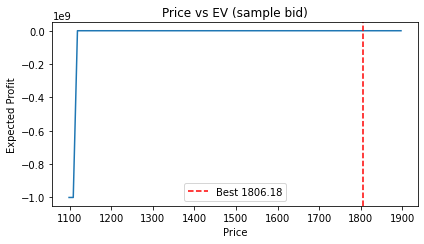

In [12]:
# Demo optimization on a sample bid

sample = df.sample(1).iloc[0]
sqft = int(sample['sqft'])
cost = float(sample['cost'])

best_price, best_ev, grid, evs = optimize_price(cost, sqft)
print("Sample sqft:", sqft, "cost:", round(cost,2))
print("Recommended price:", round(best_price,2), "Expected profit:", round(best_ev,2))

plt.figure(figsize=(6,3.5))
plt.plot(grid, evs)
plt.axvline(best_price, color='red', linestyle='--', label=f'Best {round(best_price,2)}')
plt.xlabel('Price')
plt.ylabel('Expected Profit')
plt.title('Price vs EV (sample bid)')
plt.legend()
plt.tight_layout()
plt.show()

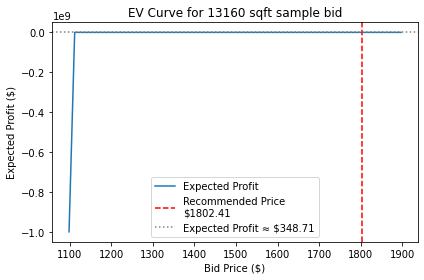

In [13]:
# Expected profit grid for the sample bid
sqft = int(sample['sqft'])
cost = float(sample['cost'])
price_grid = np.linspace(cost*1.10, cost*1.9, 60)  # start at 10% margin

evs = [expected_profit(p, sqft, cost) for p in price_grid]
best_idx = int(np.argmax(evs))
best_price = price_grid[best_idx]
best_ev = evs[best_idx]

plt.figure(figsize=(6,4))
plt.plot(price_grid, evs, label='Expected Profit')
plt.axvline(best_price, color='red', linestyle='--', label=f'Recommended Price\n${best_price:.2f}')
plt.axhline(best_ev, color='gray', linestyle=':', label=f'Expected Profit ≈ ${best_ev:.2f}')
plt.xlabel('Bid Price ($)')
plt.ylabel('Expected Profit ($)')
plt.title(f'EV Curve for {sqft} sqft sample bid')
plt.legend()
plt.tight_layout()
plt.show()